# Дальнейшее развитие

- Переформулировка задачи как замена пропусков(предсказание цены) у малоликвидных монет
- Идеи: Кластеризация монет, ввести метрики схожести монет, попробовать обучение с учителем/без
- Попробовать заменить таргет (напр:среднее по следующим 5 сделкам)
- Данные о цене металла
- Признак - ценовые сегменты аукционов
- Замена пропусков в тираже в при помощи interpolate или ffil 
- Плохо прогнозировать во временном ряду различные монеты (=> кластеризация)

In [229]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import sklearn
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime
import time
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
%matplotlib inline

In [2]:
data_slv = pd.read_csv('Nick2_slv.csv', encoding='cp1251')
data_gld = pd.read_csv('Nick2_gld.csv', encoding='cp1251').iloc[:,1:]
info_slv = pd.read_csv('infoNick2_slv.csv', encoding='cp1251')
info_gld = pd.read_csv('infoNick2_gld.csv', encoding='cp1251')

print(data_slv.shape, info_slv.shape)
print(data_gld.shape, info_gld.shape)

(185931, 7) (124, 11)
(63722, 8) (26, 11)


# Преобразование данных

In [3]:
def features_info(df):
    return pd.DataFrame({'unique_values': df.nunique(),'type': df.dtypes,'percent_missing': df.isna().sum()/len(df) * 100}).sort_values(by = 'percent_missing', ascending=False).T

In [4]:
# пропуски в покупателях - не так важно
features_info(data_slv)

,buyer,state,auction,n_bid,price,date,coin_name
unique_values,17771,8,18,239,13736,3761,122
type,object,object,object,int64,int64,object,object
percent_missing,0.287203,0,0,0,0,0,0


In [5]:
'''новый столбец - металл, где есть пропуски, на всякий случай удалим, 
пропуски в покупателях тоже не важны'''
features_info(data_gld)

,metal,buyer,state,auction,n_bid,price,date,coin_name
unique_values,1,6394,6,15,255,18616,2874,25
type,object,object,object,object,int64,int64,object,object
percent_missing,4.25599,0.566523,0,0,0,0,0,0


In [6]:
# пропуски в тираже заполним
features_info(info_slv)

,circulation,letters,catalog_num,mint,metal,weight,pure_metal_content,diameter,obverse,reverse,coin_name
unique_values,101,13,124,3,2,7,7,7,50,115,124
type,object,object,object,object,object,object,object,object,object,object,object
percent_missing,14.5161,4.03226,0,0,0,0,0,0,0,0,0


In [7]:
features_info(info_gld)

,circulation,catalog_num,letters,mint,metal,weight,pure_metal_content,diameter,obverse,reverse,coin_name
unique_values,22,26,4,1,1,4,4,4,26,24,26
type,object,object,object,object,object,object,object,object,object,object,object
percent_missing,11.5385,0,0,0,0,0,0,0,0,0,0


In [197]:
totimestamp = lambda s, f: np.int32(time.mktime(datetime.strptime(s, f).timetuple()))
todate = lambda x: datetime.fromtimestamp(x)

In [9]:
def modify_dataset(df):
    df['state'] = df['state'].map({'G':1, 'VG':2, 'FALSE':3, 'VF':4, 'XF':5, 'AU':6, 'UNC':7, 'Proof':8})
    df['timestamp'] = df['date'].map(lambda x: totimestamp(x, f="%Y-%m-%d"))
    df['auction'] = df['auction'].map({k: v for v, k in enumerate(df['auction'].unique(), start=1)})
    df.drop(['buyer'],axis = 1, inplace = True)
    return df

In [10]:
def modify_info_dataset(df):
    df['coin_year'] = df['coin_name'].map(lambda x: int(x.split()[2]))
    df['cop_nominal'] = df['coin_name'].map(lambda x: int(x.split()[0]) if x.split()[1] == 'копеек,'
                                                                        else float(x.split()[0].replace(',','.'))*100 )
    df['weight'] = df['weight'].map(lambda x: x.split()[0].replace(',','.')).astype('float')
    df['diameter'] = df['diameter'].map(lambda x: x.split()[0].replace(',','.')).astype('float')
    df['pure_metal_content'] = df['pure_metal_content'].map(lambda x: x.split()[0].replace(',','.')).astype('float')
    df['circulation'] = df['circulation'].dropna().map(lambda x: int(''.join(x.split())[:-3]))
    df['circulation'].fillna(df['circulation'].dropna().median(), inplace = True)
    df['proba'] = df['metal'].map(lambda x: x.split()[2][:-1])
    df['metal'] = df['metal'].map(lambda x: x.split()[0]).map({'серебро':1, 'золото':2})
    
    mint_dummies = pd.get_dummies(df['mint'], prefix='mint')
    proba_dummies = pd.get_dummies(df['proba'], prefix = 'proba')
    df = pd.concat([df,mint_dummies, proba_dummies],axis=1)
    
    df.drop(['catalog_num', 'letters', 'obverse', 'reverse', 'mint', 'proba'], axis = 1, inplace = True)
    return df

In [11]:
data_gld.dropna(subset = ['metal'], inplace = True)
data_gld.drop(columns = ['metal'],inplace = True)
m_data_slv = modify_dataset(data_slv)
m_data_gld = modify_dataset(data_gld)
m_info_slv = modify_info_dataset(info_slv)
m_info_gld = modify_info_dataset(info_gld)

In [12]:
m_data_slv.head()

,state,auction,n_bid,price,date,coin_name,timestamp
0,4,1,42,4555,2021-10-21,"10 копеек, 1895 год",1634763600
1,4,1,15,2942,2021-09-02,"10 копеек, 1895 год",1630530000
2,4,1,13,2465,2021-07-22,"10 копеек, 1895 год",1626901200
3,4,1,13,3288,2021-07-01,"10 копеек, 1895 год",1625086800
4,4,1,25,2772,2021-05-27,"10 копеек, 1895 год",1622062800


In [13]:
m_data_gld.head()

,state,auction,n_bid,price,date,coin_name,timestamp
0,7.0,1,29,30442,2021-11-04,"5 рублей, 1897 год",1635973200
1,7.0,1,40,30442,2021-11-04,"5 рублей, 1897 год",1635973200
2,7.0,1,17,38702,2021-10-07,"5 рублей, 1897 год",1633554000
3,7.0,1,33,34461,2021-10-07,"5 рублей, 1897 год",1633554000
4,7.0,1,58,29507,2021-09-30,"5 рублей, 1897 год",1632949200


In [14]:
m_info_slv.head()

,circulation,metal,weight,pure_metal_content,diameter,coin_name,coin_year,cop_nominal,mint_Брюссельский,mint_Парижский,mint_Санкт-Петербургский,proba_500/1000,proba_900/1000
0,7750020.0,1,3.6,1.8,22.0,"20 копеек, 1901 год",1901,20.0,0,0,1,1,0
1,7417514.0,1,3.6,1.8,22.0,"20 копеек, 1902 год",1902,20.0,0,0,1,1,0
2,10000014.0,1,3.6,1.8,22.0,"20 копеек, 1903 год",1903,20.0,0,0,1,1,0
3,13000010.0,1,3.6,1.8,22.0,"20 копеек, 1904 год",1904,20.0,0,0,1,1,0
4,11000000.0,1,3.6,1.8,22.0,"20 копеек, 1905 год",1905,20.0,0,0,1,1,0


In [15]:
m_info_gld.head()

,circulation,metal,weight,pure_metal_content,diameter,coin_name,coin_year,cop_nominal,mint_Санкт-Петербургский,proba_900/1000
0,2019009.0,2,8.6,7.74,22.5,"10 рублей, 1902 год",1902,1000.0,1,1
1,2817019.0,2,8.6,7.74,22.5,"10 рублей, 1903 год",1903,1000.0,1,1
2,1024510.0,2,8.6,7.74,22.5,"10 рублей, 1904 год",1904,1000.0,1,1
3,10.0,2,8.6,7.74,22.5,"10 рублей, 1906 год",1906,1000.0,1,1
4,2377021.0,2,8.6,7.74,22.5,"10 рублей, 1909 год",1909,1000.0,1,1


In [16]:
def group_dataset(df):
    return df.groupby(['coin_name', 'state'], as_index=False).agg({'price' : 'median', 
                                                                'n_bid' : 'median', 
                                                                'timestamp' : 'max',
                                                                'auction' : 'count'})

In [17]:
data_slv_grouped = group_dataset(data_slv)
data_gld_grouped = group_dataset(data_gld)

In [18]:
merged_data_slv = data_slv_grouped.merge(m_info_slv, how='inner', on='coin_name')
merged_data_gld = data_gld_grouped.merge(m_info_gld, how='inner', on='coin_name')

In [137]:
data_slv_gld = pd.concat([merged_data_slv, merged_data_gld])

In [153]:
data_slv_gld = data_slv_gld.fillna({'mint_Брюссельский':0, 'mint_Парижский':0, 'proba_500/1000':0})

In [154]:
data_slv_gld.sort_values('timestamp', inplace=True)
data_slv_gld.shape

(633, 18)

In [166]:
data_slv_gld.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 633 entries, 82 to 283
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   coin_name                 633 non-null    object 
 1   state                     633 non-null    float64
 2   price                     633 non-null    float64
 3   n_bid                     633 non-null    float64
 4   timestamp                 633 non-null    int64  
 5   auction                   633 non-null    int64  
 6   circulation               633 non-null    float64
 7   metal                     633 non-null    int64  
 8   weight                    633 non-null    float64
 9   pure_metal_content        633 non-null    float64
 10  diameter                  633 non-null    float64
 11  coin_year                 633 non-null    int64  
 12  cop_nominal               633 non-null    float64
 13  mint_Брюссельский         633 non-null    float64
 14  mint_Пари

# Учет влияния внешних факторов на цену

In [167]:
# котировка рубли-доллары по дням
dollar_value = pd.read_csv('dol_price.txt')[['<DATE>', '<CLOSE>']]
dollar_value.rename(columns={'<DATE>' : 'date', '<CLOSE>' : 'dollar_value'}, inplace=True)
dollar_value.head()

,date,dollar_value
0,20110101,30.552
1,20110102,30.525
2,20110103,30.533
3,20110104,30.376
4,20110105,30.635


In [168]:
# инфляция доллара по месяцам
inflation = pd.read_csv('inflation.txt', encoding='cp1251', sep='\t')[['Дата выпуска', 'Время']]
inflation.rename(columns={'Дата выпуска' : 'timestamp', 'Время' : 'inf_value'}, inplace=True)
inflation.head()

,timestamp,inf_value
0,10.12.2021 (нояб),"0,8%"
1,10.11.2021 (окт),"0,9%"
2,13.10.2021 (сент),"0,4%"
3,14.09.2021 (авг),"0,3%"
4,11.08.2021 (июль),"0,5%"


In [163]:
def with_dollar_and_infliation(df, dollar_value, inflation):
    # перевод времени
    dollar_value['timestamp'] = dollar_value['date'].map(lambda x: totimestamp(str(x), "%Y%m%d"))
    dollar_value.drop('date', axis=1, inplace=True)
    
    # соединяем котировки и датасет
    df = df.merge(dollar_value, how='inner', on='timestamp')
    # перевод рублей в доллары
    df['dollar_price'] = df['price'] / df['dollar_value']

    # обработка данных об инфляции
    inflation['timestamp'] = inflation['timestamp'].map(lambda x: totimestamp(re.split('\\s\\(', x)[0], f='%d.%m.%Y'))
    inflation['inf_value'] = inflation['inf_value'].map(lambda x: float(x[:-1].replace(',', '.')))
    inflation['inf_coef'] = 1 - inflation['inf_value'] / 100

    n_month = inflation.shape[0] - 1
    inflation.at[n_month, 'inf_coef'] = 1
    inflation.sort_values('timestamp', inplace=True)
    for i in range(1, n_month + 1):
        inflation.at[n_month - i, 'inf_coef'] = inflation.iloc[i - 1]['inf_coef'] * inflation.iloc[i]['inf_coef']

    inflation = inflation.set_index('timestamp')
    inflation = inflation.reindex(range(inflation.index[0], inflation.index[-1] + 86400, 86400), method='pad')

    df = df.merge(inflation, how='inner', on='timestamp')

    df['inf_dollar_price'] = df['dollar_price'] * df['inf_coef']
    df.drop(['inf_value'], axis=1, inplace=True)
    return df

In [169]:
data = with_dollar_and_infliation(data_slv_gld, dollar_value, inflation)

In [170]:
data

,coin_name,state,price,n_bid,timestamp,auction,circulation,metal,weight,pure_metal_content,...,cop_nominal,mint_Брюссельский,mint_Парижский,mint_Санкт-Петербургский,proba_500/1000,proba_900/1000,dollar_value,dollar_price,inf_coef,inf_dollar_price
0,"50 копеек, 1902 год",5.0,88560.0,106.0,1297026000,1,36009.0,1,10.00,9.000,...,50.0,0.0,0.0,1,0.0,1,29.2580,3026.864447,1.000000,3026.864447
1,"5 копеек, 1898 год",3.0,138.5,51.0,1297803600,2,3980009.0,1,0.90,0.450,...,5.0,0.0,0.0,1,1.0,0,29.1980,4.743476,1.000000,4.743476
2,"10 рублей, 1909 год",4.0,17375.0,24.0,1300395600,3,2377021.0,2,8.60,7.740,...,1000.0,0.0,0.0,1,0.0,1,28.4450,610.827914,0.991020,605.342679
3,"15 копеек, 1915 год",3.0,44.0,18.0,1301000400,33,59333333.0,1,2.70,1.350,...,15.0,0.0,0.0,1,1.0,0,28.2770,1.556035,0.991020,1.542062
4,"20 копеек, 1917 год",8.0,82187.0,16.5,1301086800,6,3500000.0,1,3.60,1.800,...,20.0,0.0,0.0,1,1.0,0,28.2760,2906.599236,0.991020,2880.497975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,"5 копеек, 1901 год",4.0,343.0,33.0,1635973200,375,5790020.0,1,0.90,0.450,...,5.0,0.0,0.0,1,1.0,0,71.2985,4.810760,0.806001,3.877479
591,"15 копеек, 1908 год",5.0,187.0,21.0,1635973200,1742,29000009.0,1,2.70,1.350,...,15.0,0.0,0.0,1,1.0,0,71.2985,2.622776,0.806001,2.113961
592,"7,5 рублей, 1897 год",6.0,39330.0,32.0,1635973200,891,16829000.0,2,6.45,5.805,...,750.0,0.0,0.0,1,0.0,1,71.2985,551.624508,0.806001,444.610052
593,"5 рублей, 1900 год",7.0,13551.0,26.0,1635973200,1061,31077013.0,2,4.30,3.870,...,500.0,0.0,0.0,1,0.0,1,71.2985,190.060099,0.806001,153.188681


In [171]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595 entries, 0 to 594
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   coin_name                 595 non-null    object 
 1   state                     595 non-null    float64
 2   price                     595 non-null    float64
 3   n_bid                     595 non-null    float64
 4   timestamp                 595 non-null    int64  
 5   auction                   595 non-null    int64  
 6   circulation               595 non-null    float64
 7   metal                     595 non-null    int64  
 8   weight                    595 non-null    float64
 9   pure_metal_content        595 non-null    float64
 10  diameter                  595 non-null    float64
 11  coin_year                 595 non-null    int64  
 12  cop_nominal               595 non-null    float64
 13  mint_Брюссельский         595 non-null    float64
 14  mint_Париж

# Смотрим на данные

In [172]:
pearson = data.corr().round(2)
pearson

,state,price,n_bid,timestamp,auction,circulation,metal,weight,pure_metal_content,diameter,...,cop_nominal,mint_Брюссельский,mint_Парижский,mint_Санкт-Петербургский,proba_500/1000,proba_900/1000,dollar_value,dollar_price,inf_coef,inf_dollar_price
state,1.00,0.30,0.26,0.27,0.01,-0.02,0.09,-0.03,-0.02,-0.05,...,0.08,-0.06,-0.10,0.11,-0.02,0.02,0.24,0.30,-0.25,0.30
price,0.30,1.00,0.41,-0.05,-0.14,-0.17,0.09,0.31,0.32,0.31,...,0.13,-0.02,-0.04,0.05,-0.36,0.36,-0.04,0.97,0.06,0.96
n_bid,0.26,0.41,1.00,-0.04,-0.25,-0.35,-0.12,0.43,0.44,0.42,...,-0.06,0.00,-0.07,0.05,-0.38,0.38,-0.00,0.43,0.08,0.43
timestamp,0.27,-0.05,-0.04,1.00,0.47,0.07,0.10,0.01,0.02,-0.02,...,0.10,0.02,-0.04,0.02,-0.05,0.05,0.89,-0.15,-0.97,-0.17
auction,0.01,-0.14,-0.25,0.47,1.00,0.30,0.24,-0.03,-0.03,-0.04,...,0.22,0.11,-0.03,-0.04,-0.06,0.06,0.34,-0.16,-0.55,-0.16
circulation,-0.02,-0.17,-0.35,0.07,0.30,1.00,-0.11,-0.24,-0.26,-0.18,...,-0.14,0.05,0.07,-0.09,0.30,-0.30,0.04,-0.17,-0.08,-0.17
metal,0.09,0.09,-0.12,0.10,0.24,-0.11,1.00,0.03,0.06,-0.08,...,0.92,-0.04,-0.05,0.07,-0.46,0.46,0.04,0.07,-0.15,0.06
weight,-0.03,0.31,0.43,0.01,-0.03,-0.24,0.03,1.00,1.00,0.96,...,0.19,0.22,0.08,-0.20,-0.77,0.77,0.02,0.31,-0.01,0.31
pure_metal_content,-0.02,0.32,0.44,0.02,-0.03,-0.26,0.06,1.00,1.00,0.95,...,0.22,0.22,0.09,-0.20,-0.81,0.81,0.03,0.32,-0.01,0.31
diameter,-0.05,0.31,0.42,-0.02,-0.04,-0.18,-0.08,0.96,0.95,1.00,...,0.07,0.20,0.11,-0.21,-0.72,0.72,-0.00,0.30,0.03,0.30


In [173]:
def find_anomalies_index(data):
    lower_limit  = data.quantile(0.25) - 1.5 * (data.quantile(0.75)-data.quantile(0.25))
    upper_limit = data.quantile(0.75) + 1.5 * (data.quantile(0.75)-data.quantile(0.25))
    return data.loc[(data > upper_limit) | (data<lower_limit)].index

In [174]:
anomalies = find_anomalies_index(data['inf_dollar_price'])
print('percent of anomalies in feature price is', round(len(anomalies)/data_slv.shape[0],4))

percent of anomalies in feature price is 0.0004


In [175]:
anomalies

Int64Index([  0,   2,   4,   5,   8,   9,  12,  13,  16,  20,  23,  24,  26,
             29,  30,  32,  38,  51,  54,  56,  58,  83,  84,  87,  91,  92,
             93,  95, 119, 123, 129, 134, 137, 143, 144, 160, 167, 177, 181,
            182, 196, 197, 199, 216, 220, 230, 239, 253, 260, 283, 307, 316,
            318, 323, 387, 389, 419, 431, 436, 448, 460, 485, 512, 530, 534,
            547, 557, 564],
           dtype='int64')

In [176]:
data.loc[anomalies].state.unique()

array([5., 4., 8., 6., 7.])

In [263]:
pd.set_option('display.max_rows', 68)

In [264]:
u = data.loc[anomalies].groupby(['coin_name','metal','state']).median()
u.head(68)

price  n_bid   timestamp  auction  \
coin_name            metal state                                         
1 рубль, 1895 год    1     7.0    148393.5   64.5  1413406800       12   
1 рубль, 1899 год    1     7.0     64226.0   39.0  1599080400       82   
1 рубль, 1902 год    1     7.0    185883.0   24.5  1481749200       10   
1 рубль, 1903 год    1     5.0     58887.0   41.0  1544648400      134   
1 рубль, 1904 год    1     4.0    101762.5   56.0  1623272400       48   
                           5.0    137700.0   42.0  1452114000       15   
1 рубль, 1905 год    1     4.0     64614.0   41.0  1620248400      115   
                           5.0    119566.5   50.5  1510174800       42   
                           7.0    124814.0   58.0  1354568400        3   
1 рубль, 1906 год    1     6.0    118357.0   79.0  1528318800       17   
                           7.0    162820.0   58.0  1462395600        7   
1 рубль, 1907 год    1     7.0     66469.5   39.5  1615410000       98   
1 рубль, 1908 год    1     4.0     35911.0   37.0  1411592400       30   
                           5.0     56121.0   47.0  1625691600       65   
                           6.0     89444.0   52.0  1460581200       10   
                           7.0    182741.5   58.0  1521061200       14   
1 рубль, 1909 год    1     6.0     89609.5   53.0  1521061200       32   
                           7.0    121499.5   48.0  1507755600       36   
1 рубль, 1910 год    1     6.0     67448.0   47.5  1568840400       36   
                           7.0     99668.5   55.5  1622667600       88   
1 рубль, 1911 год    1     7.0     62229.0   40.0  1615410000      157   
                           8.0    279999.5   33.0  1495054800       20   
1 рубль, 1913 год    1     4.0     38000.5   39.0  1344373200       12   
                           5.0     68686.5   51.0  1484168400       56   
                           6.0    119000.0   36.0  1461704400       11   
                           7.0    139817.0   51.0  1627506000       75   
1 рубль, 1914 год    1     6.0     40284.5   38.0  1489006800      100   
                           7.0     52065.0   41.0  1595451600      116   
1 рубль, 1915 год    1     7.0     66665.0   42.0  1635368400      420   
10 копеек, 1906 год  1     8.0     29404.0    1.0  1332536400        1   
10 копеек, 1907 год  1     8.0     19481.0   34.0  1312923600        4   
10 копеек, 1916 год  1     8.0     53846.0   31.0  1567630800       37   
10 рублей, 1909 год  2     4.0     17375.0   24.0  1300395600        3   
10 рублей, 1910 год  2     5.0     69999.0   32.0  1412974800       77   
                           6.0     80634.5   35.5  1554325200       78   
                           7.0    129227.0   38.0  1633554000      237   
15 копеек, 1904 год  1     8.0     28287.0   30.0  1340053200        5   
15 копеек, 1913 год  1     8.0     20500.0   18.0  1305666000        9   
15 копеек, 1915 год  1     8.0     25325.0   30.5  1320181200        8   
15 рублей, 1897 год  2     7.0     61499.0   33.0  1635973200     1431   
20 копеек, 1917 год  1     6.0     33000.0   40.0  1356469200       15   
                           7.0     58939.0   45.0  1635973200      153   
                           8.0     82187.0   16.5  1301086800        6   
25 копеек, 1896 год  1     8.0     94792.0   35.5  1310504400        4   
25 копеек, 1900 год  1     6.0     27140.5   34.0  1402520400       20   
                           7.0     50561.0   51.5  1532552400       58   
25 копеек, 1901 год  1     8.0    693439.5   22.5  1591218000       16   
5 копеек, 1912 год   1     8.0     19464.0   38.0  1326229200        9   
5 копеек, 1913 год   1     8.0     51461.0   28.0  1557954000       16   
5 рублей, 1909 год   2     5.0     23000.0   32.5  1378328400       54   
5 рублей, 1910 год   2     5.0     36553.5   33.0  1341349200       24   
                           6.0     43500.0   27.0  1318021200       12   
                           7.0     93593.

In [266]:
data.loc[anomalies].coin_name.value_counts()

1 рубль, 1908 год       4
1 рубль, 1913 год       4
5 рублей, 1910 год      3
50 копеек, 1908 год     3
1 рубль, 1905 год       3
20 копеек, 1917 год     3
50 копеек, 1902 год     3
10 рублей, 1910 год     3
1 рубль, 1911 год       2
1 рубль, 1909 год       2
1 рубль, 1910 год       2
1 рубль, 1904 год       2
25 копеек, 1900 год     2
1 рубль, 1906 год       2
1 рубль, 1914 год       2
15 копеек, 1913 год     1
25 копеек, 1896 год     1
10 рублей, 1909 год     1
1 рубль, 1903 год       1
5 копеек, 1913 год      1
10 копеек, 1916 год     1
25 копеек, 1901 год     1
5 копеек, 1912 год      1
50 копеек, 1907 год     1
1 рубль, 1915 год       1
5 рублей, 1909 год      1
50 копеек, 1906 год     1
5 рублей, 1911 год      1
1 рубль, 1907 год       1
15 копеек, 1915 год     1
50 копеек, 1913 год     1
1 рубль, 1902 год       1
7,5 рублей, 1897 год    1
50 копеек, 1904 год     1
10 копеек, 1907 год     1
15 рублей, 1897 год     1
50 копеек, 1898 год     1
1 рубль, 1895 год       1
50 копеек, 1

In [177]:
data.inf_dollar_price.describe()

count     595.000000
mean      270.997883
std       733.836280
min         0.277530
25%         4.156711
50%        29.408576
75%       234.934460
max      8700.880888
Name: inf_dollar_price, dtype: float64

In [217]:
without_anomalies = data.drop(index = anomalies)

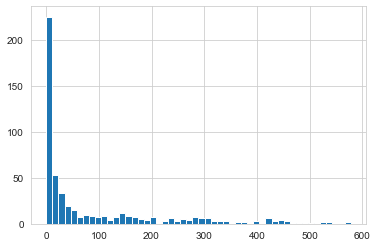

In [179]:
without_anomalies['inf_dollar_price'].hist(bins = 50)

{'whiskers': [<matplotlib.lines.Line2D at 0x223bd40a040>,
 'caps': [<matplotlib.lines.Line2D at 0x223bd40a6a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x223bd3fbd90>],
 'medians': [<matplotlib.lines.Line2D at 0x223bd40ad00>],
 'fliers': [<matplotlib.lines.Line2D at 0x223bd40afd0>],
 'means': []}

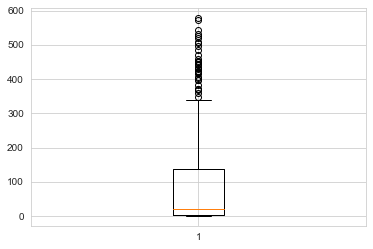

In [180]:
plt.boxplot(without_anomalies['inf_dollar_price'])

In [181]:
without_anomalies

,coin_name,state,price,n_bid,timestamp,auction,circulation,metal,weight,pure_metal_content,...,cop_nominal,mint_Брюссельский,mint_Парижский,mint_Санкт-Петербургский,proba_500/1000,proba_900/1000,dollar_value,dollar_price,inf_coef,inf_dollar_price
1,"5 копеек, 1898 год",3.0,138.5,51.0,1297803600,2,3980009.0,1,0.90,0.450,...,5.0,0.0,0.0,1,1.0,0,29.1980,4.743476,1.000000,4.743476
3,"15 копеек, 1915 год",3.0,44.0,18.0,1301000400,33,59333333.0,1,2.70,1.350,...,15.0,0.0,0.0,1,1.0,0,28.2770,1.556035,0.991020,1.542062
6,"25 копеек, 1896 год",2.0,388.5,27.5,1307653200,12,19212032.0,1,5.00,4.500,...,25.0,0.0,0.0,1,0.0,1,28.0085,13.870789,0.982121,13.622788
7,"20 копеек, 1908 год",3.0,90.0,21.0,1309467600,28,5000009.0,1,3.60,1.800,...,20.0,0.0,0.0,1,1.0,0,27.8200,3.235083,0.980156,3.170887
10,"10 копеек, 1914 год",8.0,15843.0,31.0,1317157200,7,51250015.0,1,1.80,0.900,...,10.0,0.0,0.0,1,1.0,0,31.7900,498.364265,0.973297,485.056596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,"5 копеек, 1901 год",4.0,343.0,33.0,1635973200,375,5790020.0,1,0.90,0.450,...,5.0,0.0,0.0,1,1.0,0,71.2985,4.810760,0.806001,3.877479
591,"15 копеек, 1908 год",5.0,187.0,21.0,1635973200,1742,29000009.0,1,2.70,1.350,...,15.0,0.0,0.0,1,1.0,0,71.2985,2.622776,0.806001,2.113961
592,"7,5 рублей, 1897 год",6.0,39330.0,32.0,1635973200,891,16829000.0,2,6.45,5.805,...,750.0,0.0,0.0,1,0.0,1,71.2985,551.624508,0.806001,444.610052
593,"5 рублей, 1900 год",7.0,13551.0,26.0,1635973200,1061,31077013.0,2,4.30,3.870,...,500.0,0.0,0.0,1,0.0,1,71.2985,190.060099,0.806001,153.188681


Но:количество появлений различных монет на разных аукционах отличается

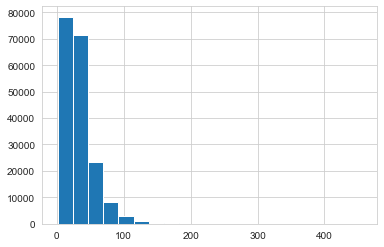

In [255]:
data.n_bid.hist(bins = 20)

In [256]:
info['mint'].value_counts()

Санкт-Петербургский    121
Парижский                2
Брюссельский             1
Name: mint, dtype: int64

### buyer - Какие покупатели какую цену дают

In [261]:
times_buy = data['buyer'].value_counts().iloc[:50]
times_buy.head()

jimmysu    1228
imi         805
mefodi      790
оса         672
enter       622
Name: buyer, dtype: int64

In [262]:
most_buyers = data.groupby('buyer', as_index=False)['price'].mean().sort_values(by='price',ascending=False).iloc[:50]#.hist(bins = 20)
most_buyers.head()

,buyer,price
3734,Pavlooshka,193610.000000
17352,сoeli,190536.000000
3470,Nicki,185462.461538
15788,Слоник,181910.000000
10710,olenka.10,165100.000000


In [263]:
(set(most_buyers)).intersection(set(times_buy))

set()

Покупатели, которые чаще покупают не входят в список покупателей самых дорогих монет

buyer - удаляем признак, т.к. в общем случае неприменим, но можно покопаться и дальше

## state

In [264]:
data.state.value_counts()

VF       65321
XF       57924
UNC      29650
AU       26795
FALSE     5283
G          381
VG         355
Proof      222
Name: state, dtype: int64

In [265]:
data.groupby('state').mean().sort_values(by='price',ascending=False)

,n_bid,price
state,,
Proof,31.981982,146973.391892
UNC,33.467386,11417.773963
XF,31.970634,3247.122816
AU,30.150998,3058.784960
VF,32.218551,1414.468272
FALSE,28.561045,655.104297
G,32.157480,507.590551
VG,25.459155,237.647887


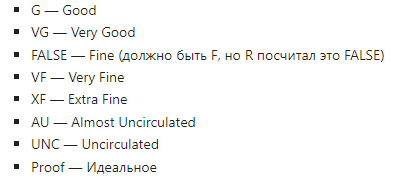

надо преобразовать признак. разница между xf и au небольшая

# auction

In [270]:
data.auction.value_counts()

Wolmar VIP                      50960
Конрос                          45934
Wolmar Стандарт                 30912
Аукцион СПБ                     19630
Numizma                          7197
Anumis                           6337
Reviewdetector                   6078
Habe                             6034
UCoins                           5428
Монетоф                          4133
Ефимок                           1288
Легенда                           831
Александр (интернет аукцион)      510
Монеты и медали                   333
Coins.su                          127
Thaler on-line                     91
Александр (очный аукцион)          90
Аргентум                           18
Name: auction, dtype: int64

In [267]:
data.groupby('auction').median().sort_values(by='price',ascending=False)

,n_bid,price
auction,,
Александр (очный аукцион),1.0,46407.5
Монеты и медали,1.0,18000.0
Александр (интернет аукцион),3.0,6800.0
Wolmar VIP,30.0,4099.0
Coins.su,6.0,2000.0
Reviewdetector,8.0,520.0
Ефимок,22.0,509.5
Монетоф,25.0,271.0
Numizma,11.0,265.0


на разных аукционах разные медианные значения цены проданных монет, но лучше посмотрим по отдельным монетам

In [268]:
dff = data.groupby(['coin_name','auction','state']).median()

In [269]:
dff.head(30)

n_bid     price
coin_name         auction                   state                 
1 рубль, 1895 год Coins.su                  XF       1.0   10000.0
                  Habe                      VF     123.0    7300.0
                  Numizma                   VF      26.0   10381.0
                                            XF      22.0   14874.0
                  Reviewdetector            VF      16.0    5250.0
                                            XF      32.5    8775.0
                  Wolmar VIP                UNC     67.0  147900.0
                                            VF      40.0    7070.0
                                            XF      38.0   21499.0
                  Wolmar Стандарт           VF      48.5    3891.0
                  Александр (очный аукцион) UNC      1.0  201162.0
                  Аукцион СПБ               VF      56.0    7142.0
                  Ефимок                    VF      14.0    5610.0
                  Конрос                    VF      55.0    5762.5
                  Монеты и медали           FALSE    1.0   10000.0
                                            VF       1.0   10250.0
                                            XF       1.0   40000.0
1 рубль, 1896 год Anumis                    VF      95.5    1646.0
                                            XF      88.5    4028.0
                  Coins.su                  VF       7.0    1750.0
                  Habe                      FALSE   46.0     731.5
                                            VF      29.5     757.0
                                            VG      57.0     464.0
                                            XF      51.0    8897.0
                  Numizma                   AU      19.5   15506.5
                                            VF      15.0    1165.0
                                            XF      25.0    7140.0
                  Reviewdetector            VF      13.0    1475.0
                                            XF      18.5    3150.5
                  UCoins                    VF      14.5    1134.0

Можно ввести новый признак - аукцион начального/среднего/VIP ценового сегмента

# Пробуем добавлять фичи

- Временные признаки (год, месяц) - низкая корреляция между ценой
- Лаги - по графику автокорреляции нет значимых

In [218]:
without_anomalies

,coin_name,state,price,n_bid,timestamp,auction,circulation,metal,weight,pure_metal_content,...,cop_nominal,mint_Брюссельский,mint_Парижский,mint_Санкт-Петербургский,proba_500/1000,proba_900/1000,dollar_value,dollar_price,inf_coef,inf_dollar_price
1,"5 копеек, 1898 год",3.0,138.5,51.0,1297803600,2,3980009.0,1,0.90,0.450,...,5.0,0.0,0.0,1,1.0,0,29.1980,4.743476,1.000000,4.743476
3,"15 копеек, 1915 год",3.0,44.0,18.0,1301000400,33,59333333.0,1,2.70,1.350,...,15.0,0.0,0.0,1,1.0,0,28.2770,1.556035,0.991020,1.542062
6,"25 копеек, 1896 год",2.0,388.5,27.5,1307653200,12,19212032.0,1,5.00,4.500,...,25.0,0.0,0.0,1,0.0,1,28.0085,13.870789,0.982121,13.622788
7,"20 копеек, 1908 год",3.0,90.0,21.0,1309467600,28,5000009.0,1,3.60,1.800,...,20.0,0.0,0.0,1,1.0,0,27.8200,3.235083,0.980156,3.170887
10,"10 копеек, 1914 год",8.0,15843.0,31.0,1317157200,7,51250015.0,1,1.80,0.900,...,10.0,0.0,0.0,1,1.0,0,31.7900,498.364265,0.973297,485.056596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,"5 копеек, 1901 год",4.0,343.0,33.0,1635973200,375,5790020.0,1,0.90,0.450,...,5.0,0.0,0.0,1,1.0,0,71.2985,4.810760,0.806001,3.877479
591,"15 копеек, 1908 год",5.0,187.0,21.0,1635973200,1742,29000009.0,1,2.70,1.350,...,15.0,0.0,0.0,1,1.0,0,71.2985,2.622776,0.806001,2.113961
592,"7,5 рублей, 1897 год",6.0,39330.0,32.0,1635973200,891,16829000.0,2,6.45,5.805,...,750.0,0.0,0.0,1,0.0,1,71.2985,551.624508,0.806001,444.610052
593,"5 рублей, 1900 год",7.0,13551.0,26.0,1635973200,1061,31077013.0,2,4.30,3.870,...,500.0,0.0,0.0,1,0.0,1,71.2985,190.060099,0.806001,153.188681


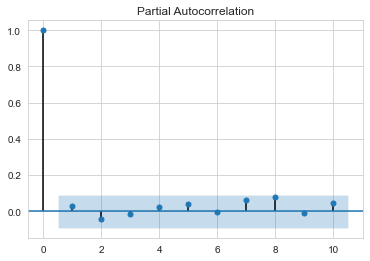

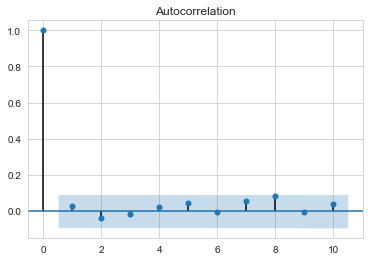

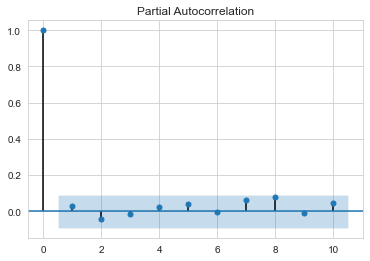

In [230]:
plot_acf(without_anomalies[without_anomalies['metal']== 1]['inf_dollar_price'], lags=10)
plot_pacf(without_anomalies[without_anomalies['metal']== 1]['inf_dollar_price'], lags=10)

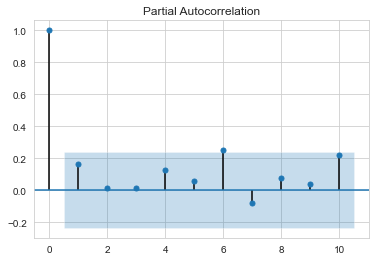

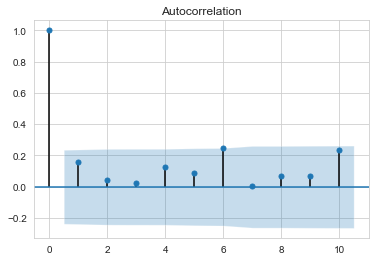

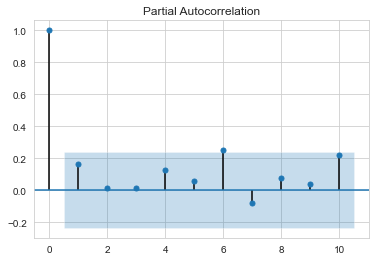

In [231]:
plot_acf(without_anomalies[without_anomalies['metal']== 2]['inf_dollar_price'], lags=10)
plot_pacf(without_anomalies[without_anomalies['metal']== 2]['inf_dollar_price'], lags=10)

In [270]:
without_anomalies['3dayEWM'] = without_anomalies['inf_dollar_price'].ewm(span=3, adjust=False).mean()
without_anomalies['4dayEWM'] = without_anomalies['inf_dollar_price'].ewm(span=4, adjust=False).mean()
without_anomalies['5dayEWM'] = without_anomalies['inf_dollar_price'].ewm(span=5, adjust=False).mean()

In [271]:
without_anomalies.corr()

,state,price,n_bid,timestamp,auction,circulation,metal,weight,pure_metal_content,diameter,...,mint_Санкт-Петербургский,proba_500/1000,proba_900/1000,dollar_value,dollar_price,inf_coef,inf_dollar_price,4dayEWM,5dayEWM,3dayEWM
state,1.000000,0.328941,0.275593,0.437768,0.085487,0.005928,0.117742,-0.108771,-0.103140,-0.132359,...,0.104810,0.042781,-0.042781,0.407213,0.303637,-0.392297,0.293899,0.297130,0.293758,0.300534
price,0.328941,1.000000,0.414001,0.187052,0.040748,-0.263254,0.553181,0.484112,0.504640,0.395737,...,0.031902,-0.616799,0.616799,0.150022,0.980098,-0.185682,0.967876,0.781404,0.730400,0.843354
n_bid,0.275593,0.414001,1.000000,0.060558,-0.220075,-0.370971,-0.121012,0.339577,0.351131,0.318614,...,0.036141,-0.296659,0.296659,0.092919,0.419856,-0.012119,0.425767,0.353319,0.333386,0.377633
timestamp,0.437768,0.187052,0.060558,1.000000,0.471459,0.042061,0.125114,0.058213,0.067486,0.023376,...,0.046588,-0.109184,0.109184,0.876371,0.103004,-0.969223,0.072475,0.154809,0.176234,0.131454
auction,0.085487,0.040748,-0.220075,0.471459,1.000000,0.290507,0.252652,0.051648,0.053855,0.035503,...,-0.023722,-0.131675,0.131675,0.321740,0.008984,-0.551272,-0.012694,0.016344,0.028291,0.004617
circulation,0.005928,-0.263254,-0.370971,0.042061,0.290507,1.000000,-0.110930,-0.189904,-0.211853,-0.119254,...,-0.079151,0.252514,-0.252514,0.015770,-0.265206,-0.053338,-0.265578,-0.227567,-0.212998,-0.243302
metal,0.117742,0.553181,-0.121012,0.125114,0.252652,-0.110930,1.000000,0.086817,0.121991,-0.040489,...,0.070865,-0.508526,0.508526,0.068812,0.540576,-0.165232,0.522946,0.410484,0.382443,0.445218
weight,-0.108771,0.484112,0.339577,0.058213,0.051648,-0.189904,0.086817,1.000000,0.996768,0.957885,...,-0.253493,-0.777233,0.777233,0.046563,0.485916,-0.058449,0.487386,0.422761,0.396723,0.452905
pure_metal_content,-0.103140,0.504640,0.351131,0.067486,0.053855,-0.211853,0.121991,0.996768,1.000000,0.938965,...,-0.257895,-0.811767,0.811767,0.054498,0.505808,-0.068012,0.506619,0.437457,0.410480,0.468853
diameter,-0.132359,0.395737,0.318614,0.023376,0.035503,-0.119254,-0.040489,0.957885,0.938965,1.000000,...,-0.266019,-0.710450,0.710450,0.018507,0.398720,-0.022156,0.402408,0.358532,0.337921,0.382039


# Тестирование модели

In [236]:
X = without_anomalies.drop(["timestamp", "coin_name", "price", 'metal', 'weight', 'inf_dollar_price', 'dollar_price' ], axis=1)
y = without_anomalies["inf_dollar_price"]

In [237]:
index_test = round(X.shape[0]*0.8)

In [238]:
X_train = X.iloc[:index_test]
y_train = y.iloc[:index_test]
X_test = X.iloc[index_test:]
y_test = y.iloc[index_test:]

In [241]:
X_train.shape

(422, 16)

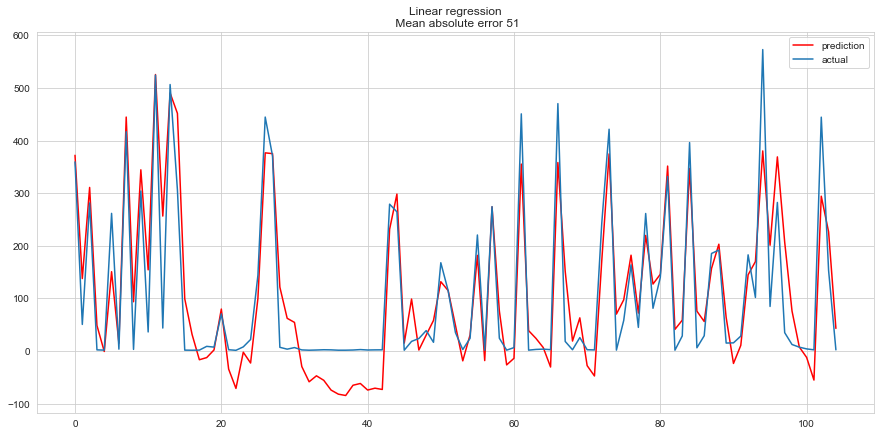

In [239]:
#gold plus silver
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(lr_prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {}".format(round(mean_absolute_error(lr_prediction, y_test))))
plt.grid(True);

In [190]:
lr_negative_pred = pd.Series(x for x in lr_prediction if x <0)
lr_negative_pred

0    -344.845656
1    -149.881612
2    -474.202478
3    -448.223606
4    -491.464160
5    -523.270200
6    -592.965564
7    -516.144395
8    -554.901436
9    -336.795966
10   -424.650882
11   -531.358187
12   -269.526383
13   -312.275802
14   -196.843236
15   -165.781825
16   -545.868881
17   -254.267750
18   -433.252104
19   -370.928455
20   -484.528354
21   -540.920891
22   -262.408550
23   -484.965418
24   -364.222591
25   -312.610815
26   -330.967393
27   -565.797743
28   -422.890314
29   -235.420332
30   -517.092288
31   -512.917446
32   -296.738843
33   -507.641585
34   -216.928146
35   -180.680704
36   -231.381165
37   -220.421662
38    -53.847004
39   -273.727396
40   -497.436579
41   -269.998762
42   -243.413553
43    -91.474258
44   -194.845824
45   -319.012974
46   -433.684846
47   -297.684673
48    -57.613030
dtype: float64

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

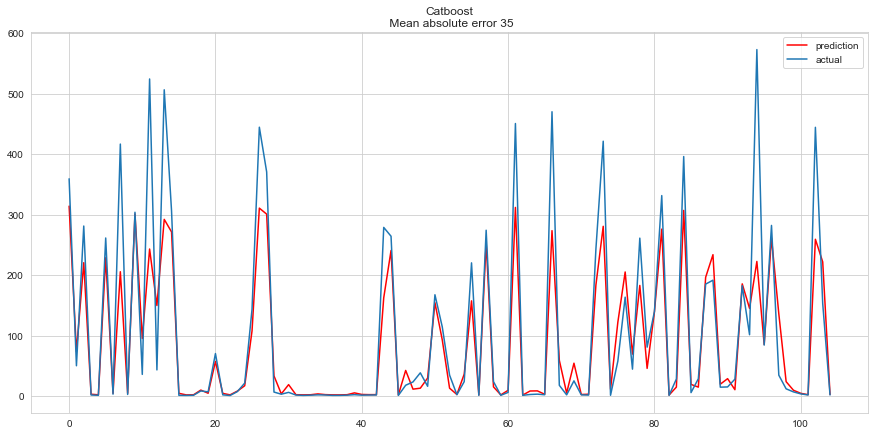

In [240]:
cat = CatBoostRegressor(loss_function='MAE', iterations = 100 )

cat.fit(X_train,y_train,verbose=False, plot=True)

prediction = cat.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Catboost\n Mean absolute error {}".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

In [202]:
negative_pred = pd.Series(x for x in prediction if x < 0)
negative_pred

Series([], dtype: float64)